In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from PIL import Image

import matplotlib.pyplot as plt
import koreanize_matplotlib

In [3]:
# 디바이스 설정(GPU 사용 가능 시 GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 데이터 로딩
data_dir = '../image/'  # sunny, others 폴더 위치

In [ ]:
# transform
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]) 







In [6]:
# ==============================
# 4. 데이터셋 불러오기 (transform 적용 X)
# ==============================
full_dataset = datasets.ImageFolder(root=data_dir)
print(f"클래스 라벨: {full_dataset.classes}")  # ['others', 'sunny']

클래스 라벨: ['others', 'sunny']


In [7]:
# ==============================
# 5. 데이터셋 split
# ==============================
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
valid_size = int(0.2 * total_size)
test_size = total_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    full_dataset, [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# split 후 transform 적용
train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_transform
test_dataset.dataset.transform = valid_transform

In [8]:
# ==============================
# 6. DataLoader 설정
# ==============================
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# ==============================
# 7. CNN 모델 정의
# ==============================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 모델 인스턴스화
model = CNN().to(device)

In [10]:
# ==============================
# 8. 손실함수, 옵티마이저, 스케줄러 설정
# ==============================
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # 5 epoch마다 학습률 감소

In [21]:
# 9. 모델 학습 및 검증 반복
num_epochs = 30  # 전체 학습 반복 횟수
best_valid_acc = 0.0  # 가장 높은 검증 정확도를 저장하는 변수
best_model_path = './best_cnn_sunny_others.pt'  # 최고 모델 저장 경로

for epoch in range(num_epochs):  # Epoch 반복 시작
    model.train()  # 모델을 학습 모드로 전환
    train_loss = 0  # 누적 학습 손실 초기화
    train_preds = []  # 전체 예측값 저장 리스트
    train_labels = []  # 실제 정답값 저장 리스트

    # === 학습 데이터 반복 ===
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        labels = labels.view(-1, 1)  # BCELoss를 위한 shape 맞춤: (batch_size, 1)

        optimizer.zero_grad()  # 이전 그래디언트 초기화
        outputs = model(images)  # 모델에 입력 → 출력(예측값) 생성
        loss = criterion(outputs, labels)  # 손실 계산 (예측 vs 실제)
        loss.backward()  # 역전파로 그래디언트 계산
        optimizer.step()  # 파라미터 업데이트

        train_loss += loss.item()  # 손실 누적
        preds = (outputs >= 0.5).float()  # 0.5 이상이면 1, 아니면 0으로 변환 (binary classification)
        train_preds.extend(preds.cpu().numpy())  # 예측값 저장 (numpy 변환)
        train_labels.extend(labels.cpu().numpy())  # 실제값 저장

    # 학습 정확도 계산
    train_acc = accuracy_score(train_labels, train_preds)

    # === 검증 시작 ===
    model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 비활성)
    valid_loss = 0
    valid_preds = []
    valid_labels = []

    with torch.no_grad():  # 평가 시에는 그래디언트 계산 비활성화 (속도 향상)
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            preds = (outputs >= 0.5).float()
            valid_preds.extend(preds.cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())

    # 검증 정확도 계산
    valid_acc = accuracy_score(valid_labels, valid_preds)

    # 학습률 스케줄러 한 스텝 업데이트
    scheduler.step()

    # === 가장 높은 검증 정확도 모델 저장 ===
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc  # 최고 정확도 갱신
        torch.save(model.state_dict(), "best_cnn_sunny_others_rgb.pt")
 # 모델 저장
        print(f"📌 새로운 최고 모델 저장됨 (Epoch {epoch+1}, Valid Acc: {valid_acc:.4f})")

    # Epoch별 결과 출력
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, '
          f'Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Acc: {valid_acc:.4f}')

📌 새로운 최고 모델 저장됨 (Epoch 1, Valid Acc: 0.9500)
Epoch [1/30] - Train Loss: 0.1158, Train Acc: 0.9571, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [2/30] - Train Loss: 0.1217, Train Acc: 0.9536, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [3/30] - Train Loss: 0.1152, Train Acc: 0.9500, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [4/30] - Train Loss: 0.1148, Train Acc: 0.9536, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [5/30] - Train Loss: 0.1132, Train Acc: 0.9536, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [6/30] - Train Loss: 0.1162, Train Acc: 0.9607, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [7/30] - Train Loss: 0.1071, Train Acc: 0.9643, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [8/30] - Train Loss: 0.1164, Train Acc: 0.9464, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [9/30] - Train Loss: 0.1202, Train Acc: 0.9607, Valid Loss: 0.1445, Valid Acc: 0.9500
Epoch [10/30] - Train Loss: 0.1179, Train Acc: 0.9607, Valid Loss: 0.1445, Valid Acc: 0.9500


KeyboardInterrupt: 

In [12]:
# # ==============================
# # 9. 학습 및 검증
# # ==============================
# num_epochs = 30

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     train_preds = []
#     train_labels = []

#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.float().to(device)
#         labels = labels.view(-1, 1)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()
#         preds = (outputs >= 0.5).float()
#         train_preds.extend(preds.cpu().numpy())
#         train_labels.extend(labels.cpu().numpy())

#     train_acc = accuracy_score(train_labels, train_preds)

#     # 검증
#     model.eval()
#     valid_loss = 0
#     valid_preds = []
#     valid_labels = []

#     with torch.no_grad():
#         for images, labels in valid_loader:
#             images, labels = images.to(device), labels.float().to(device)
#             labels = labels.view(-1, 1)

#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             valid_loss += loss.item()

#             preds = (outputs >= 0.5).float()
#             valid_preds.extend(preds.cpu().numpy())
#             valid_labels.extend(labels.cpu().numpy())

#     valid_acc = accuracy_score(valid_labels, valid_preds)
#     scheduler.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}] - '
#           f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, '
#           f'Valid Loss: {valid_loss/len(valid_loader):.4f}, Valid Acc: {valid_acc:.4f}')

In [17]:
# ==============================
# 10. 최종 테스트 평가
# ==============================
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        labels = labels.view(-1, 1)

        outputs = model(images)
        preds = (outputs >= 0.5).float()
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
print(f'\n최종 Test Accuracy: {test_acc:.4f}')


최종 Test Accuracy: 0.8500


In [ ]:
# # ==============================
# # 11. 모델 저장
# # ==============================
# torch.save(model.state_dict(), 'cnn_sunny_others.pt')
# print('모델 저장 완료')

모델 저장 완료


In [18]:
# ==============================
# 12. 새로운 이미지 예측 함수
# ==============================
class_names = ['others', 'sunny']

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # 배치 차원 추가
    return image.to(device)

def predict_image(image_path):
    model = CNN().to(device)
    model.load_state_dict(torch.load('cnn_sunny_others.pt', map_location=device))
    model.eval()

    image = preprocess_image(image_path)

    with torch.no_grad():
        output = model(image)
        pred = (output >= 0.5).float()
        label = int(pred.item())
        prob = output.item()
        print(f"\n이미지: {os.path.basename(image_path)} → 예측 결과: {class_names[label]}")



이미지: 사진1.jpg → 예측 결과: sunny


C:\Users\KDP38\AppData\Local\Temp\ipykernel_23424\1185813462.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_sunny_others.pt', map

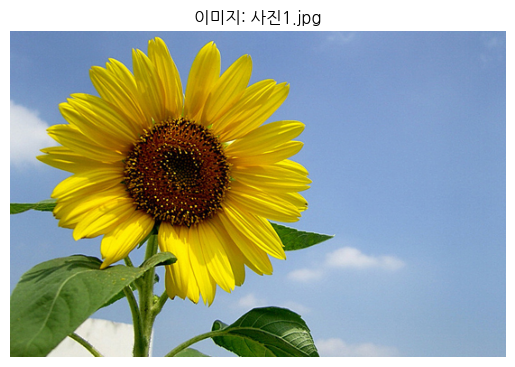

In [22]:
# ==============================
# 13. 예측 실행 예시
# ==============================
test_image_path = '../image/사진1.jpg'
predict_image(test_image_path)

# ==============================
# 14. 이미지 출력
# ==============================
img = Image.open(test_image_path).convert("RGB")
plt.imshow(img)
plt.title(f"이미지: {os.path.basename(test_image_path)}")
plt.axis('off')
plt.show()
